In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy import stats

import mpmath
import time

import pygsp as pg
import plotly

## Delay Measure framework

In [2]:
def delay_measure(signal, return_meas = False):
    n_regions = len(signal[0])
    n_timepoints = len(signal)
    
    # Initialization of data vectors
    activ = np.zeros(n_regions)
    delay_meas = np.zeros((n_regions, n_regions, n_timepoints))
    
    # Scanning through time
    for t, vox in enumerate(signal):
        # Progression Verbose
        if t % np.ceil(n_timepoints/4) == 0:
            print(t, 'out of', n_timepoints)
        
        # Compute delay and update activation list iif at least one region is active
        if any(vox):
            # Store index of previously (act) and newly (vox) activated regions 
            act_idx = np.where(activ != 0)[0]
            vox_idx = np.where(vox != 0)[0]
            
            # Computation of time delay between 
            for vox_id in vox_idx:
                delay_meas[act_idx,vox_id, t] = (t + 1 - activ[activ!=0])
            
            # Update activation list and times
            activ[np.where(vox != 0)] = t + 1
    
    print('Almost there')
    
    # Compute mean and STD of delay
    delay_mean = np.empty((n_regions, n_regions))
    delay_std = np.empty_like(delay_mean)
    
    for i in range(n_regions):
        for j in range(n_regions):
            delay_mean[i, j] = delay_meas[i, j][delay_meas[i, j] != 0].mean()
            delay_std[i, j] = delay_meas[i, j][delay_meas[i, j] != 0].std()
    
    print('––[ DONE ]––')
    
    # Condition to return actual measurements (CARE: big thing)
    if return_meas:
        return delay_meas, delay_mean, delay_std
    else:
        return delay_mean, delay_std

## Generation of random activation
Simulation of sparse innovation signals by thresholding randomly distributed signal at 95%–98% percentile.

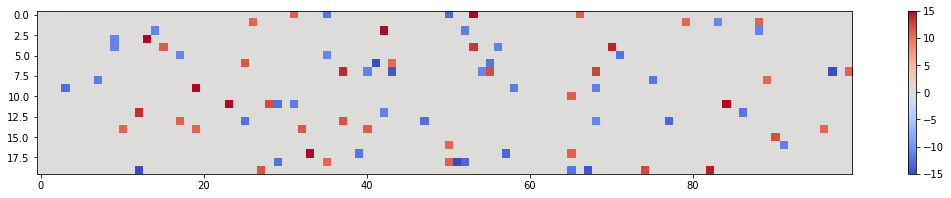

In [3]:
innovation = np.random.normal(np.zeros((100,20)), 5)
innovation[abs(innovation) < np.percentile(innovation, 98)] = 0

fig, ax = plt.subplots(figsize = (20, 3))
plt.imshow(innovation.T, cmap = 'coolwarm', vmin = -15, vmax =15)
plt.colorbar() 

# Labels!

0 out of 100
25 out of 100
50 out of 100
75 out of 100
Almost there
––[ DONE ]––


/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning:

Mean of empty slice.

/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning:

Degrees of freedom <= 0 for slice

/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning:

invalid value encountered in true_divide

/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning:

invalid value encountered in double_scalars



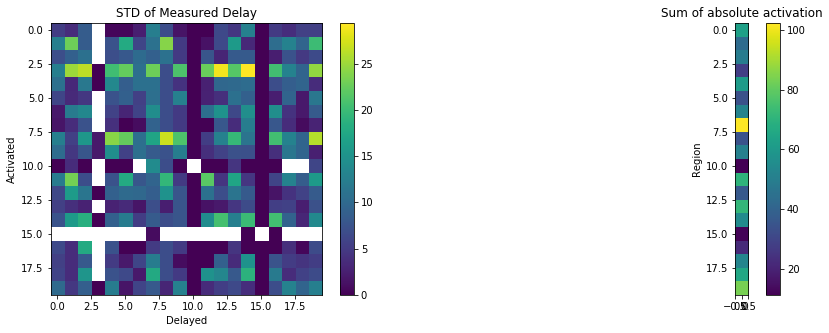

In [4]:
# Measurement of delay in synthetic data (random patterns)
delay_100_mean, delay_100_std = delay_measure(innovation)

fig, ax = plt.subplots(figsize = (14, 5))

plt.subplot(1, 2, 1)
plt.title('STD of Measured Delay')
plt.imshow(delay_100_std)
plt.xlabel('Delayed')
plt.ylabel('Activated')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('Sum of absolute activation')
plt.imshow(np.abs(innovation).sum(axis = 0).reshape(-1,1))
plt.ylabel('Region')
plt.colorbar()

## Modelisation of piece-wise constant voxel activity
- Initial state chosen as a random value
- As time passes, the probability for a transition to occur increases
- When a transition occurs:
    - The amplitude of the transition is randomly computed and applied as new constant signal
    - A new mean (for the transition amplitude distribution) is computed in order to maintain a signal centered around 0.
    - The transition probability resets (and is randomised)

In [5]:
def piecewise_activity(n_timesteps = 1000, trans_prob = 1e-3, trans_amp = 5, noise = 0):
    time_course = np.empty((n_timesteps))
    innovation = np.zeros_like(time_course)
    time_course[0] = np.random.normal(0, 5)
    last_trans = 0
    # Storing progression of numbers of draw (in binomial)
    n_draws = []

    for t in np.arange(1, n_timesteps, 1):
        if np.random.binomial(t - last_trans, trans_prob):
            # Computation of transition amplitude
            transition = np.random.normal(0, trans_amp)
            
            # Storthe progression of n_draws
            n_draws.extend(np.arange(t-last_trans))
            
            time_course[t] = transition
            last_trans = t
            
            # Randomization of transition probablity
            trans_prob = abs(np.random.normal(trans_prob, trans_prob/10))
            
            innovation[t] = transition - time_course[t-1]
        else:
            time_course[t] = time_course[t - 1]
            
    n_draws.extend(np.arange(t - last_trans))
    
    if noise:
        time_course += np.random.normal(np.zeros_like(time_course), noise)
        innovation += np.random.normal(np.zeros_like(time_course), noise)
    
    return time_course, innovation, n_draws

sig, inno, n_draws = piecewise_activity(500, trans_prob = 1e-3, noise = .2)

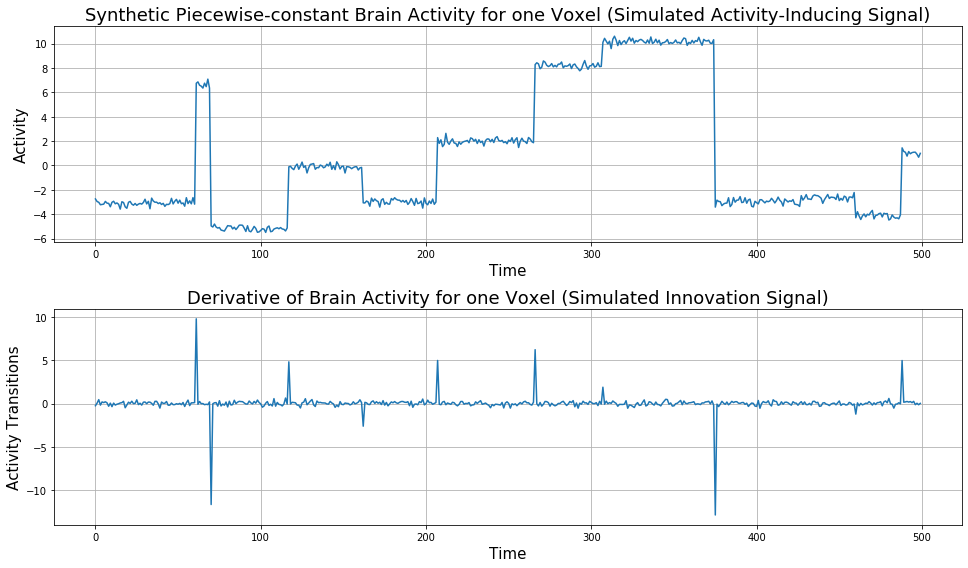

In [6]:
fig, ax = plt.subplots(figsize = (14, 8))

plt.subplot(2, 1, 1)

plt.title('Synthetic Piecewise-constant Brain Activity for one Voxel '
          '(Simulated Activity-Inducing Signal)', fontsize = 18)

plt.plot(sig)

plt.xlabel('Time', fontsize = 15)
plt.ylabel('Activity', fontsize = 15)

plt.grid()


plt.subplot(2, 1, 2)

plt.title('Derivative of Brain Activity for one Voxel '
          '(Simulated Innovation Signal)', fontsize = 18)

plt.plot(inno)

plt.xlabel('Time', fontsize = 15)
plt.ylabel('Activity Transitions', fontsize = 15)

plt.grid()

plt.tight_layout()

#plt.savefig('FIG_SynthData/Piecewise-CST')

/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



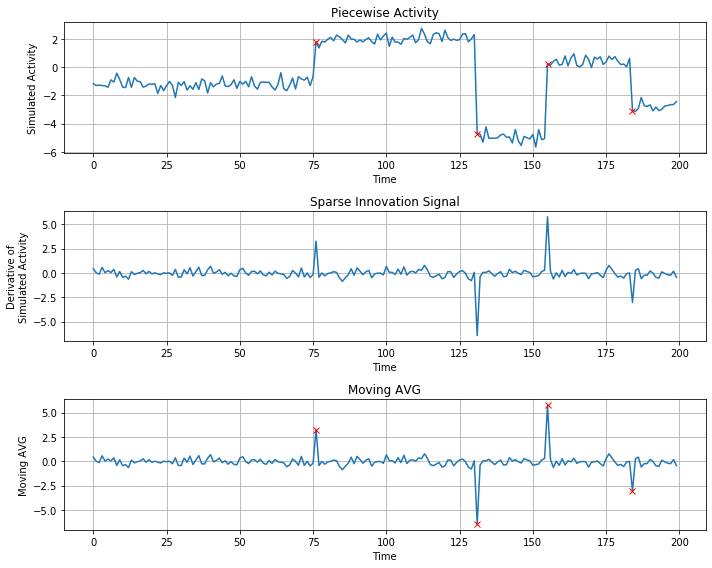

In [8]:
sig, inno, n_draws = piecewise_activity(200, trans_prob = 1e-3, noise = .3)

fig, ax = plt.subplots(figsize = (10, 8))
plt.subplot(3, 1, 1)
plt.title('Piecewise Activity')
plt.plot(sig)

plt.xlabel('Time')
plt.ylabel('Simulated Activity')

plt.grid()

plt.subplot(3, 1, 2)
plt.title('Sparse Innovation Signal')
plt.plot(inno)

plt.xlabel('Time')
plt.ylabel('Derivative of\nSimulated Activity')

plt.grid()

plt.subplot(3, 1, 3)
plt.title('Moving AVG')

plt.plot(inno)

n_avg, tol, markz, mov_avg = 10, 0.6, [], []

#for i, _ in enumerate(inno):
#    if i > n_avg-1:
#        moving_avg = abs(inno[i - n_avg:i].mean())
#        mov_avg.append([i, moving_avg])
#        if abs(inno[i]) > moving_avg + tol:
#            markz.append([i, inno[i]])
            
for i, zsc in enumerate(stats.zscore(inno)):
    if np.abs(zsc) > 1.5:
        markz.append([i, inno[i]])

plt.plot(np.array(markz).T[0], np.array(markz).T[1], 'rx')

plt.xlabel('Time')
plt.ylabel('Moving AVG')

plt.grid()

plt.subplot(3, 1, 1)
plt.plot(np.array(markz).T[0], sig[np.array(markz).T[0].astype(int)], 'rx')


plt.tight_layout()

## Patterned activation
- Some voxels or regions are randomly selected as seeds with their activity beeing the same as the one described earlier (tresholded randomly distributed signal)
- Some other voxels or regions are randomly selected as followers (of the seeds)
    - Each voxel is randomly assigned to a seed
    - The activity of a follower follows the activity of its assigned seed with a randomly distrbuted delay following a normal distribution: $\mathcal{N}(\mu_{\text{delay}}, \sigma_{\text{delay}})$
    - Also, there is a non-zero probability that the activation of a seed will not trigger the activation of a follower
- The rest of the voxels have random activity as described earlier.

In [11]:
def gen_follower(seed, delay, activ_prob = 100, rand_delay = 1, noise = 0):
    
    follower = np.zeros_like(seed)
    
    # Computation of random delay
    peaks = np.where(np.abs(stats.zscore(seed)) > 1.5)[0]
    shift = peaks + delay + np.random.normal(np.zeros_like(peaks), rand_delay)
    shift = np.ceil(shift).astype(int)
    
    # Discard activity at time larger than n_timepoints
    shift = shift[shift < len(seed)]
    
    # Assign a random value (from the value of the activity of the seed) to the followers
    follower[shift] = np.random.choice(seed[peaks], len(shift))
    
    # Randomly set activity of a follower to 0 with probability "activ_prob"
    n_rand_act = np.percentile(np.arange(len(shift)), 100 - activ_prob,
                               interpolation = 'nearest')
    n_rand_act = np.random.binomial(len(shift), 1 - activ_prob/100)
    rand_discard = np.random.choice(shift, n_rand_act)
    
    follower[rand_discard] = 0
    
    # Add random activity (regardless of the seed activity)
    unactiv_id = np.where(follower == 0)[0]
    rand_act = np.random.choice(unactiv_id, n_rand_act)

    follower[rand_act] = np.random.choice(seed[peaks], n_rand_act)
    
    added_noise = np.random.normal(np.zeros_like(seed), noise)
    follower += added_noise
    
    return follower

def simulate_activation(n_regions = 20, n_seeds = 2, n_followers = 2,
                        n_timepoints = 400, delay = 10, activ_proba = [0, 100],
                        piecewise = False, **kwargs):
    # Initialization of time course
    time_course = np.empty((n_regions, n_timepoints))

    # Random group allocation of region id
    non_random_id = np.random.choice(n_regions, n_seeds + n_followers, replace = False)
    
    seeds_id = non_random_id[:n_seeds]
    followers_id = non_random_id[n_seeds:n_seeds + n_followers]
    
    # Use of innovation signals from piecewise constant voxel activity
    if piecewise:
        for i in np.arange(n_regions):
            _, time_course[i], _ = piecewise_activity(n_timepoints, **kwargs)
    # Use of random, sparse innovation signals
    else:
        # Initialization of time course with random activities
        time_course = np.random.normal(np.zeros((n_regions, n_timepoints)), 1)

        # Generation of random activity (all regions)
        for region in time_course:
            thresh = np.percentile(region, 100 - activ_proba[0])
            region[abs(region) < thresh] = 0
    
    # Generation of followers states (random choice of seed)
    seed_choice = []
    for i in range(n_followers):
        seed_choice.append(np.random.choice(n_seeds))
        chosen = time_course[seeds_id[seed_choice[i]]]
        # Generation of follower
        time_course[followers_id[i]] = gen_follower(chosen, delay, activ_proba[1], **kwargs)
    
    return time_course, seeds_id, followers_id, seed_choice

[2, 2, 1, 2]


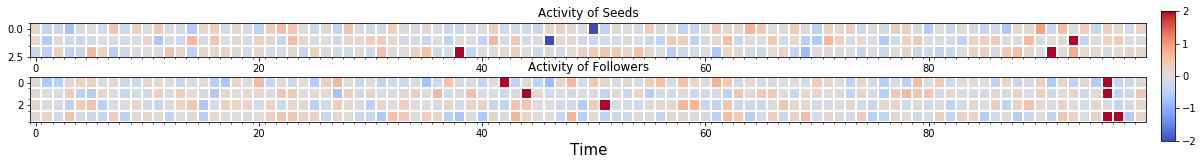

In [12]:
sim, s_ids, f_ids, s_choice = simulate_activation(n_timepoints = 100,
                                                  n_seeds = 3, n_followers = 4,
                                                  activ_proba = [0, 90], delay = 5,
                                                  piecewise = True, noise = .3)
print(s_choice)

images = []

fig, ax = plt.subplots(figsize = (20, 2))

ax1 = plt.subplot(2, 1, 1)
plt.title('Activity of Seeds', fontsize = 12)
images.append(plt.imshow(sim[s_ids], cmap = 'coolwarm', vmin = -2, vmax = 2))

# Minor ticks
ax1.set_xticks(np.arange(-.5, 99, 1), minor=True);
ax1.set_yticks(np.arange(-.5, 3, 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='w', linestyle='-', linewidth=2)

ax1 = plt.subplot(2, 1, 2)
plt.title('Activity of Followers', fontsize = 12)
images.append(plt.imshow(sim[f_ids], cmap = 'coolwarm', vmin = -2, vmax = 2))

# Minor ticks
ax1.set_xticks(np.arange(-.5, 99, 1), minor=True);
ax1.set_yticks(np.arange(-.5, 4, 1), minor=True);

# Gridlines based on minor ticks
ax1.grid(which='minor', color='w', linestyle='-', linewidth=2)
plt.xlabel('Time', fontsize = 15)

#fig.colorbar(images[0], ax = ax, orientation = 'horizontal', fraction = .1, anchor = (1, 0))
cax = plt.axes([0.91, 0.01, .01, .9])
plt.colorbar(cax = cax)

In [13]:
sim, s_ids, f_ids, s_choice = simulate_activation(n_timepoints = 200,
                                                  n_seeds = 1, n_followers = 1,
                                                  activ_proba = [0, 90], delay = 5,
                                                  piecewise = True, noise = .2)

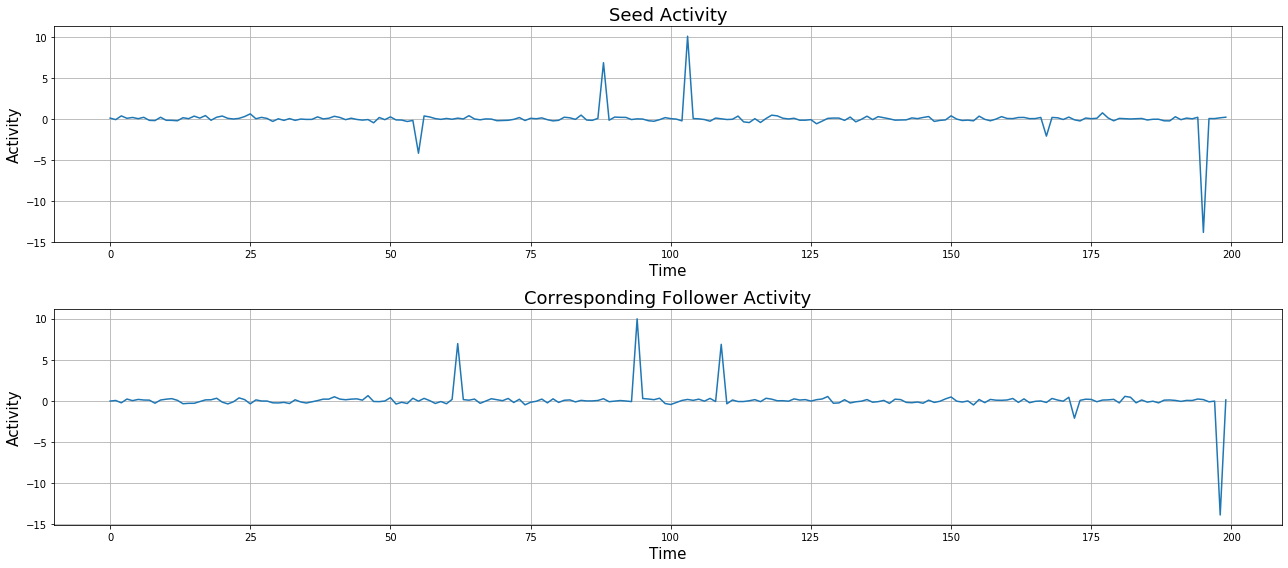

In [14]:
fig, ax = plt.subplots(figsize = (18, 8))

plt.subplot(2, 1, 1)
plt.title('Seed Activity', fontsize = 18)

plt.plot(sim[s_ids[0]].T)

plt.xlabel('Time', fontsize = 15)
plt.ylabel('Activity', fontsize = 15)
plt.grid()

plt.subplot(2, 1, 2)
plt.title('Corresponding Follower Activity', fontsize = 18)

plt.plot(sim[f_ids[0]].T)

plt.xlabel('Time', fontsize = 15)
plt.ylabel('Activity', fontsize = 15)
plt.grid()

plt.tight_layout()

#plt.savefig('FIG_SynthData/SeedFollower')

## Validation of Delay Framework

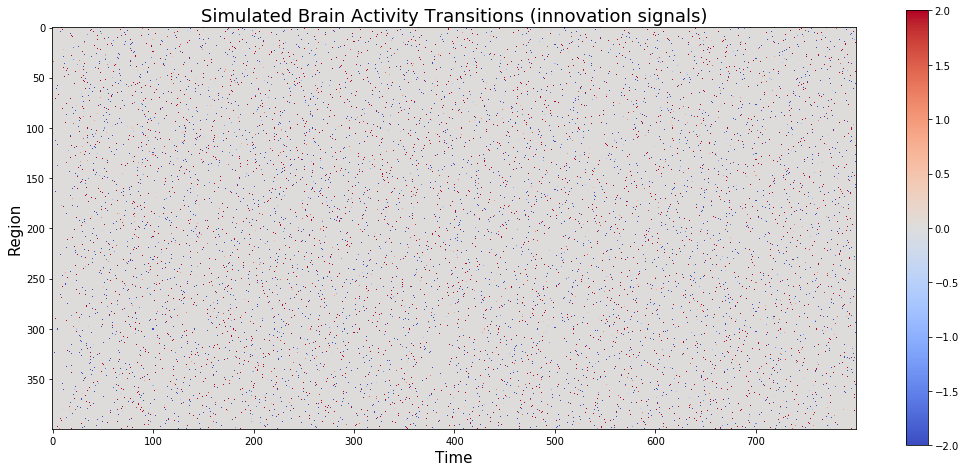

In [18]:
simulation, seed_id, fol_id, seed_choice = simulate_activation(n_regions = 400,
                                                               n_seeds = 10,
                                                               n_followers = 20,
                                                               n_timepoints = 800,
                                                               activ_proba = [0, 95],
                                                               delay = 5, piecewise = True,
                                                               noise = 0)

fig, ax = plt.subplots(figsize = (18, 8))
plt.title('Simulated Brain Activity Transitions (innovation signals)', fontsize = 18)

plt.imshow(simulation, cmap = 'coolwarm', vmin = -2, vmax = 2)

plt.xlabel('Time', fontsize = 15)
plt.ylabel('Region', fontsize = 15)

plt.colorbar()

#plt.savefig('FIG_SynthData/WholeSim')

0 out of 800
200 out of 800
400 out of 800
600 out of 800
Almost there
––[ DONE ]––


/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



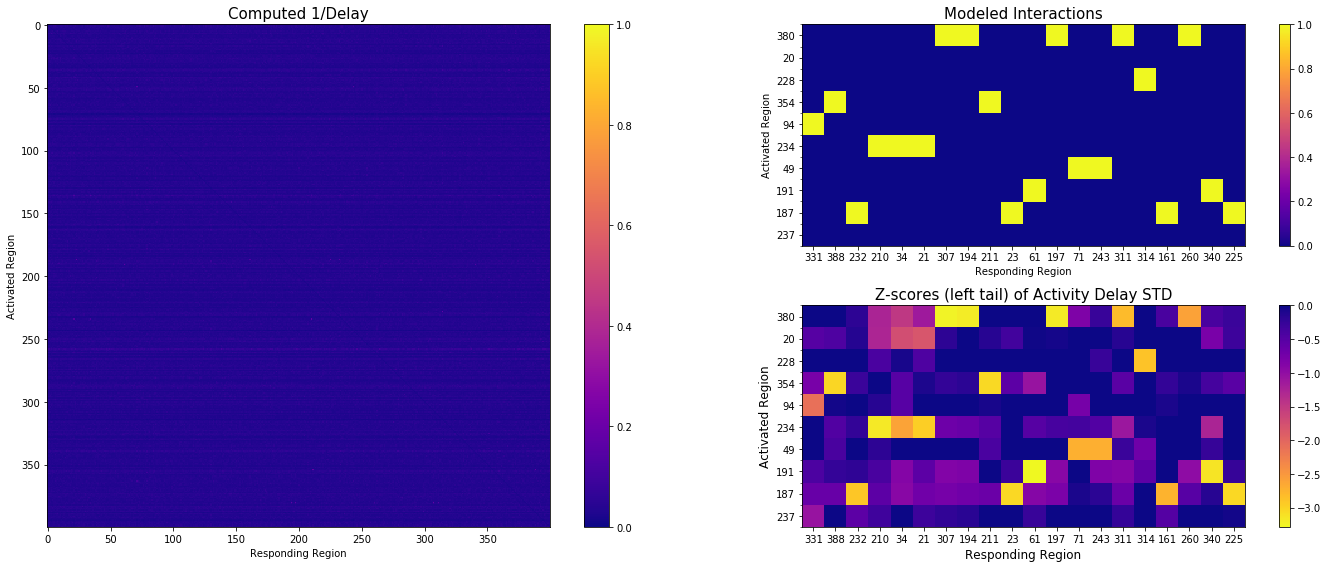

In [19]:
colmap = 'plasma'

del_std, _ = delay_measure(simulation.T)
zscores = stats.zscore(del_std)
zscores_n = zscores/np.nanmin(zscores)

fig, ax = plt.subplots(figsize = (20, 8))

# Plotting 1/Delay Matrix
sub_ax = plt.subplot(1, 2, 1)
plt.title('Computed 1/Delay', fontsize = 15)

plt.xlabel('Responding Region')
plt.ylabel('Activated Region')

plt.imshow(1/del_std, cmap = colmap, vmin = 0, vmax = 1)
plt.colorbar()

# Plotting Expected ROI
sub_ax = plt.subplot(2, 2, 2)
plt.title('Modeled Interactions', fontsize = 15)

highlight = [[i for i in seed_id for j in fol_id], [j for i in seed_id for j in fol_id]]

expected = np.zeros_like(del_std)

for f_id, chosen in zip(fol_id, seed_choice):
    expected[seed_id[seed_choice], fol_id] = 1

plt.imshow(expected[highlight].reshape(len(seed_id), -1), cmap = colmap, vmin = 0, vmax = 1)

plt.xlabel('Responding Region')
plt.ylabel('Activated Region')

sub_ax.set_xticks(np.arange(len(fol_id)))
sub_ax.set_yticks(np.arange(len(seed_id)))
sub_ax.set_yticks(np.arange(len(seed_id)+1)-0.5, minor = True)

sub_ax.set_yticklabels(seed_id)
sub_ax.set_xticklabels(fol_id)
plt.colorbar()

# Plotting Obtained ROI
sub_ax = plt.subplot(2, 2, 4)
plt.title('Z-scores (left tail) of Activity Delay STD', fontsize = 15)

highlight = [[i for i in seed_id for j in fol_id], [j for i in seed_id for j in fol_id]]

plt.imshow(zscores[highlight].reshape(len(seed_id), -1),
           cmap = 'plasma_r', vmax = 0)

plt.xlabel('Responding Region', fontsize = 12)
plt.ylabel('Activated Region', fontsize = 12)

sub_ax.set_xticks(np.arange(len(fol_id)))
sub_ax.set_yticks(np.arange(len(seed_id)))
sub_ax.set_yticks(np.arange(len(seed_id)+1)-0.5, minor = True)

sub_ax.set_yticklabels(seed_id)
sub_ax.set_xticklabels(fol_id)

plt.colorbar()

plt.tight_layout()

/Users/AlexCionca/miniconda3/envs/STD/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



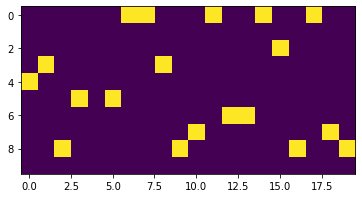

In [20]:
my = np.zeros_like(del_std)

for i, dabest in enumerate(np.argmax(1/del_std, axis = 0)):
    my[dabest, i] = 1
    
plt.imshow(my[highlight].reshape(len(seed_id), -1))